In [19]:
import math 
import os
import trimesh

import torch
import torch.nn as nn
import torchvision
from torch.utils.tensorboard import SummaryWriter


from src.data.adversarial import AdversarialDataProvider
from src.data.reconstruction import ReconstructionDataProvider
from src.models.stylist import Stylist
from src.models.generator import Generator
from src.models.discriminator import Discriminator
from src.render.mesh_renderer import MeshPointsRenderer
from src.utilities.util import make_faces, grid_to_list

class Trainer:
    
    def __init__(self, config):
        self.G_noise_amp =  config.G_noise_amp
        self.z_size = config.latent_size
        size = config.adversarial_data_patch_size
        self.faces = make_faces(size, size)
        
        self.device = torch.device("cuda")
        
        self.writer = SummaryWriter()
        # Data providers
        self.RDP = ReconstructionDataProvider(config)
        self.ADP = AdversarialDataProvider(config)
        
        self.S = Stylist(config).to(self.device)
        self.G = Generator(config).to(self.device)
        self.D = Discriminator(config).to(self.device)
        self.R = MeshPointsRenderer(config).to(self.device)
        self.R.setup(self.device)
        
        # Optimizers
        self.optim_G = torch.optim.Adam(self.G.parameters(), lr=0.0001)
        self.optim_S = torch.optim.Adam(self.S.parameters(), lr=0.0001)
        self.optim_D = torch.optim.Adam(self.D.parameters(), lr=0.0001)
        # Loss functions
        self.adversarial_loss = nn.BCELoss()
        self.reconstruction_loss = nn.L1Loss()
        
    def step(self):
        pass
        
    
    def adversarial_step(self):
        batch, mean_std = self.ADP.next_batch(labels=True, device=self.device)
        images, points = batch['large'], batch['points'] # ?????
        label_real = batch['label_real']
        label_fake = batch['label_fake']
        
        # (1) Update Discriminator
        ## Train with all-real batch
        self.optim_D.zero_grad()
        output = self.D(images)        
        errD_real =  self.adversarial_loss(output, label_real)
        errD_real.backward()
        D_x = output.mean().item() 
        
        ## Train with all-fake batch
        style = self.S(images)
        pts =  self.G(points, style)
        g_images = self.R(pts, mean_std=mean_std, align=True)
        output = self.D(g_images.detach())  
        errD_fake = self.adversarial_loss(output, label_fake)    
        errD_fake.backward()
        
        self.optim_D.step()
        
        # (2) Update Generator and Stylist
        self.optim_S.zero_grad()
        self.optim_G.zero_grad()
        
        output = self.D(g_images)    
        errG = self.adversarial_loss(output, label_real)
        errG.backward()
        
        self.optim_S.step()
        self.optim_G.step()                
        
        return {
            'errD_real': errD_real.item(),
            'errD_fake': errD_fake.item(),
            'errD': (errD_real + errD_fake).item(),
            'errG': errD_fake.item(),
        }
        
    def reconstruction_step(self):
        batch = self.RDP.next_batch(self.device)        
        pts_fine = batch['points']
        bs = pts_fine.size(0)
        
        pts_noise = pts_fine + torch.randn_like(pts_fine) * self.G_noise_amp
        style = torch.zeros(bs, self.z_size, device=self.device)
        
        self.optim_G.zero_grad()
        
        vertices = self.G(pts_noise, style)
        errG_rec = self.reconstruction_loss(vertices, pts_fine)
        
        errG_rec.backward()
        
        self.optim_G.step()
        return {
            'errG_rec': errG_rec.item(),
        }
    
    def checkpoint(self, log_dir, step):
        torch.save(self.G.state_dict(), os.path.join(log_dir, f'G{step}.pth'))
        torch.save(self.S.state_dict(), os.path.join(log_dir, f'S{step}.pth'))
        torch.save(self.D.state_dict(), os.path.join(log_dir, f'D{step}.pth'))
    
    def log_loss(self, losses, step_no):
        for key in losses.keys():
            self.writer.add_scalar(f'Loss/{key}', losses[key], step_no)
    
    def log_stl(self, step_no):
        mesh_dir = os.path.join(self.writer.log_dir, 'mesh')
        if not os.path.exists(mesh_dir):
            os.makedirs(mesh_dir)
            
        batch, mean_std = self.ADP.next_batch(labels=False, device=self.device)
        images, points = batch['large'], batch['points']                
                
        with torch.no_grad():
            style = self.S(images)
            style[0] = 0 # Default style
            pts_batch =  grid_to_list(self.G(points, style))
            for i, pts in enumerate(pts_batch):
                vertices = pts.detach().cpu()
                mesh = trimesh.Trimesh(vertices=vertices, faces=self.faces)
                mesh.export(os.path.join(mesh_dir, f'mesh_{step_no}_{i}.stl'))
                
    def log_images(self, step_no):
        batch, _ = self.ADP.next_batch(labels=False, device=self.device)
        images, points = batch['large'], batch['points'] 
        
        with torch.no_grad():
            style = self.S(images)
            style[0] = 0 # Default style
            pts =  self.G(points, style)
            pts[-1] = points[-1] # One default point
            
            g_images = self.R(pts, mean_std=None, align=True)
            print(g_images.shape)
            nrow = math.ceil(g_images.size(0) / 2.)
            grid = torchvision.utils.make_grid(g_images, nrow=nrow)
            self.writer.add_image('images', grid, step_no)
            
        

from src.config import get_parser

config = get_parser().parse_args(args=[])    
trainer = Trainer(config)
trainer

torch.Size([16, 3, 512, 512])


torch.Size([8, 1, 128, 128])


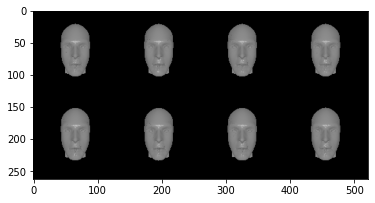

In [18]:
import matplotlib.pyplot as plt 

self = trainer

batch, _ = self.ADP.next_batch(labels=False, device=self.device)
images, points = batch['large'], batch['points'] 

g_images_2 = self.R(points, mean_std=None, align=True)
print(g_images_2.shape)
grid_2 = torchvision.utils.make_grid(g_images_2, nrow=4)
#self.writer.add_image('images', grid, step_no+1)



plt.imshow(grid_2.permute(1, 2, 0).cpu());    

In [20]:
trainer.log_images(1)

torch.Size([8, 1, 128, 128])


In [31]:
trainer.log_stl(11)

In [8]:
writer.log_dir
trainer.checkpoint(writer.log_dir, 0)

In [5]:
import random
random.random()

0.9127995548808574

In [32]:
epochs = 100
steps = len(trainer.RDP) + len(trainer.ADP)

threshold = len(trainer.RDP) / len(trainer.ADP)

for epoch_no in range(epochs):
    for step_no in range(steps):
        if True: #random.random() < 0.5: #threshold:
            losses = trainer.reconstruction_step()
        else:
            losses = trainer.adversarial_step()
        trainer.log_loss(losses, epoch_no * steps + step_no)
        if step_no % 1000 == 0:
            trainer.log_stl(step_no)
    print(epoch_no)

KeyboardInterrupt: 

In [2]:
trainer.reconstruction_step()

{'errG_rec': 0.26973843574523926}

In [10]:
s  = torch.rand((8, 4))
s

tensor([[0.0319, 0.8361, 0.5539, 0.7249],
        [0.8414, 0.6477, 0.6841, 0.8900],
        [0.0676, 0.9530, 0.3478, 0.7463],
        [0.2505, 0.2242, 0.0347, 0.2237],
        [0.0170, 0.9637, 0.8571, 0.3297],
        [0.7080, 0.7523, 0.0012, 0.0251],
        [0.6757, 0.7713, 0.1670, 0.6092],
        [0.7938, 0.4849, 0.7749, 0.1687]])

In [11]:
s[0] = 0

In [12]:
s

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.8414, 0.6477, 0.6841, 0.8900],
        [0.0676, 0.9530, 0.3478, 0.7463],
        [0.2505, 0.2242, 0.0347, 0.2237],
        [0.0170, 0.9637, 0.8571, 0.3297],
        [0.7080, 0.7523, 0.0012, 0.0251],
        [0.6757, 0.7713, 0.1670, 0.6092],
        [0.7938, 0.4849, 0.7749, 0.1687]])

In [14]:
trainer.R.faces.shape

torch.Size([1, 32258, 3])

In [15]:
128**2

16384

In [16]:
from src.utilities.util import make_faces

In [18]:
make_faces(128, 128).shape

(32258, 3)

In [8]:
pts = torch.rand(2, 3, 2, 2)
pts1 = torch.zeros(2, 3, 2, 2)
pts, pts1

(tensor([[[[0.3380, 0.5406],
           [0.1369, 0.7331]],
 
          [[0.3781, 0.6741],
           [0.8704, 0.0892]],
 
          [[0.5798, 0.1139],
           [0.6858, 0.5406]]],
 
 
         [[[0.5159, 0.1733],
           [0.8737, 0.9063]],
 
          [[0.6460, 0.7371],
           [0.2221, 0.6811]],
 
          [[0.5960, 0.5843],
           [0.6762, 0.4539]]]]),
 tensor([[[[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]]],
 
 
         [[[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]]]]))

In [10]:
pts[-1] = pts1[-1]
pts

tensor([[[[0.3380, 0.5406],
          [0.1369, 0.7331]],

         [[0.3781, 0.6741],
          [0.8704, 0.0892]],

         [[0.5798, 0.1139],
          [0.6858, 0.5406]]],


        [[[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]]]])